# Exploratory Data Analysis: Diabetic Readmission Risk
**Objective:** To investigate the quality, distribution, and structure of the dataset before modeling.

Our primary goals in this phase are:
1.  **Assess Data Quality:** Identify features with excessive missingness.
2.  **Analyze Class Balance:** Quantify the ratio of readmitted vs. non-readmitted patients to anticipate the "Accuracy Paradox."
3.  **Validate Feature Engineering:** Visualizing the impact of grouping high-cardinality features like ICD-9 diagnosis codes.

In [5]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the parent directory to path so we can import from 'src'
sys.path.append(os.path.abspath(os.path.join('..')))

from src import preprocess
from src import feature_engineering

# Plot Settings
plt.style.use('ggplot')
sns.set_palette('colorblind')

# 1. Load Raw Data (Before Cleaning) to show the "Mess"
raw_df = pd.read_csv('../data/diabetic_data.csv', na_values='?')
print(f"Original Shape: {raw_df.shape}")

Original Shape: (101766, 50)


C:\Users\conta\AppData\Local\Temp\ipykernel_26096\686554081.py:19: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('../data/diabetic_data.csv', na_values='?')


## 1. Analysis of Missing Data
Before attempting to train any model, we must identify features that lack sufficient signal. Features with extremely high missingness (>40%) often introduce more noise than value when imputed.

**Hypothesis:** Columns related to administrative details (like `payer_code`) or specific biometrics (like `weight`) may be sparsely populated in this dataset.

C:\Users\conta\AppData\Local\Temp\ipykernel_26096\2018952607.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing.values, y=missing.index, palette='viridis')


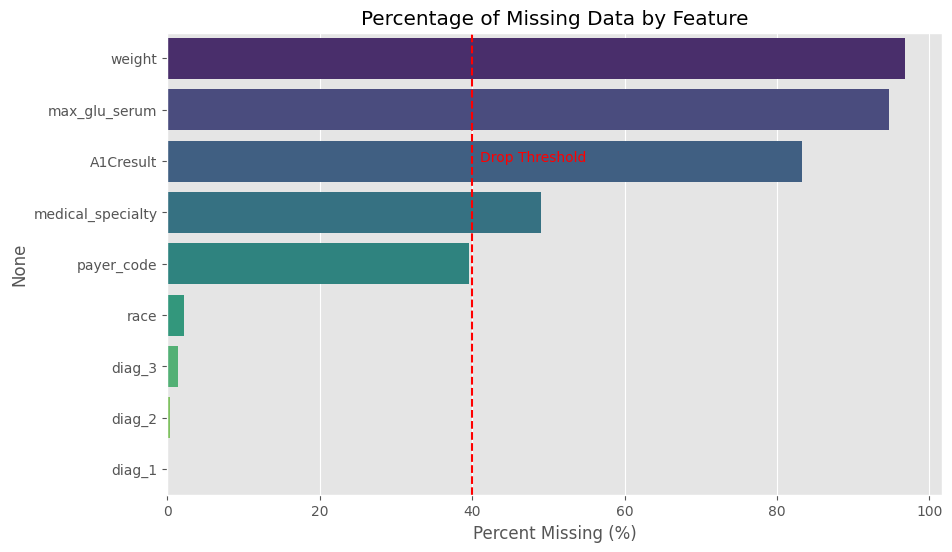

DECISION: Dropped 'weight', 'payer_code', and 'medical_specialty' due to excessive missingness.


In [6]:
# Visualize Missing Values
plt.figure(figsize=(10, 6))
missing = raw_df.isnull().sum() / len(raw_df) * 100
missing = missing[missing > 0].sort_values(ascending=False)

sns.barplot(x=missing.values, y=missing.index, palette='viridis')
plt.title('Percentage of Missing Data by Feature')
plt.xlabel('Percent Missing (%)')
plt.axvline(x=40, color='r', linestyle='--')
plt.text(41, 2, 'Drop Threshold', color='r')
plt.show()

print("DECISION: Dropped 'weight', 'payer_code', and 'medical_specialty' due to excessive missingness.")

### Decision: Feature Pruning
The visualization above reveals that `weight`, `payer_code`, and `medical_specialty` have significant missingness (up to 97% for weight).
* **Action:** We will drop these columns in the preprocessing pipeline.
* **Reasoning:** Imputing a variable that is 97% missing is statistically unsound and would lead to a model learning from synthetic noise rather than actual patient data.

---

## 2. Target Variable Distribution (The "Accuracy Paradox")
We now examine the balance of our target variable: `readmitted`. Since we are specifically interested in early readmissions (<30 days), we treat this as the Positive Class (1).

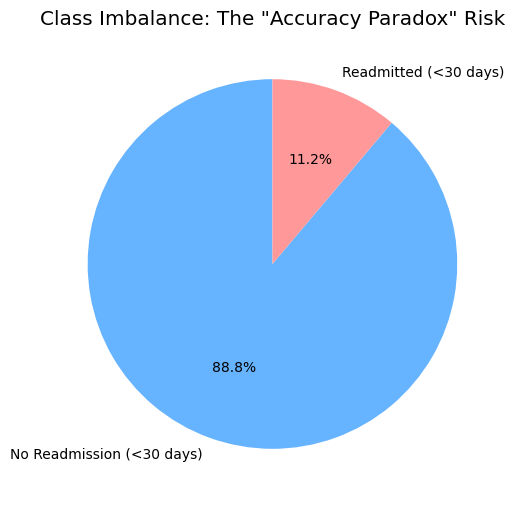

INSIGHT: Only 11% of cases are positive. A default model will get ~89% accuracy by predicting 0.


In [7]:
# Target Balance
target_counts = raw_df['readmitted'].apply(lambda x: 1 if x == '<30' else 0).value_counts(normalize=True)

plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=['No Readmission (<30 days)', 'Readmitted (<30 days)'], 
        autopct='%1.1f%%', colors=['#66b3ff','#ff9999'], startangle=90)
plt.title('Class Imbalance: The "Accuracy Paradox" Risk')
plt.show()

print("INSIGHT: Only 11% of cases are positive. A default model will get ~89% accuracy by predicting 0.")

### Insight: Severe Class Imbalance
The pie chart confirms a severe imbalance: only **11.1%** of patients are readmitted within 30 days.

* **Risk:** A naive model could achieve **~89% accuracy** simply by predicting "No Readmission" for every patient. This is the **Accuracy Paradox**.
* **Strategy:** This justifies our decision to use **SMOTE (Synthetic Minority Over-sampling Technique)** in the training pipeline and to optimize for **F1-Score/Recall** rather than raw accuracy.

---

## 3. Feature Engineering: ICD-9 Diagnosis Grouping
The raw dataset contains hundreds of unique ICD-9 medical codes (e.g., `250.01`, `414.00`). Feeding these directly into a model as One-Hot Encoded features would create a sparse, high-dimensional dataset prone to overfitting.

**Strategy:** We group these codes into 9 distinct clinical categories (e.g., "Circulatory", "Diabetes", "Respiratory") to capture the *medical theme* rather than the specific code.

Loading dataset...


c:\Users\conta\ML_Fall2025_Project\src\preprocess.py:15: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, na_values='?')


Engineering 'diag_1_group' feature...


C:\Users\conta\AppData\Local\Temp\ipykernel_26096\1970280086.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=raw_counts.values, y=raw_counts.index, ax=axes[0], palette='rocket')
C:\Users\conta\AppData\Local\Temp\ipykernel_26096\1970280086.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=group_counts.values, y=group_counts.index, ax=axes[1], palette='viridis')


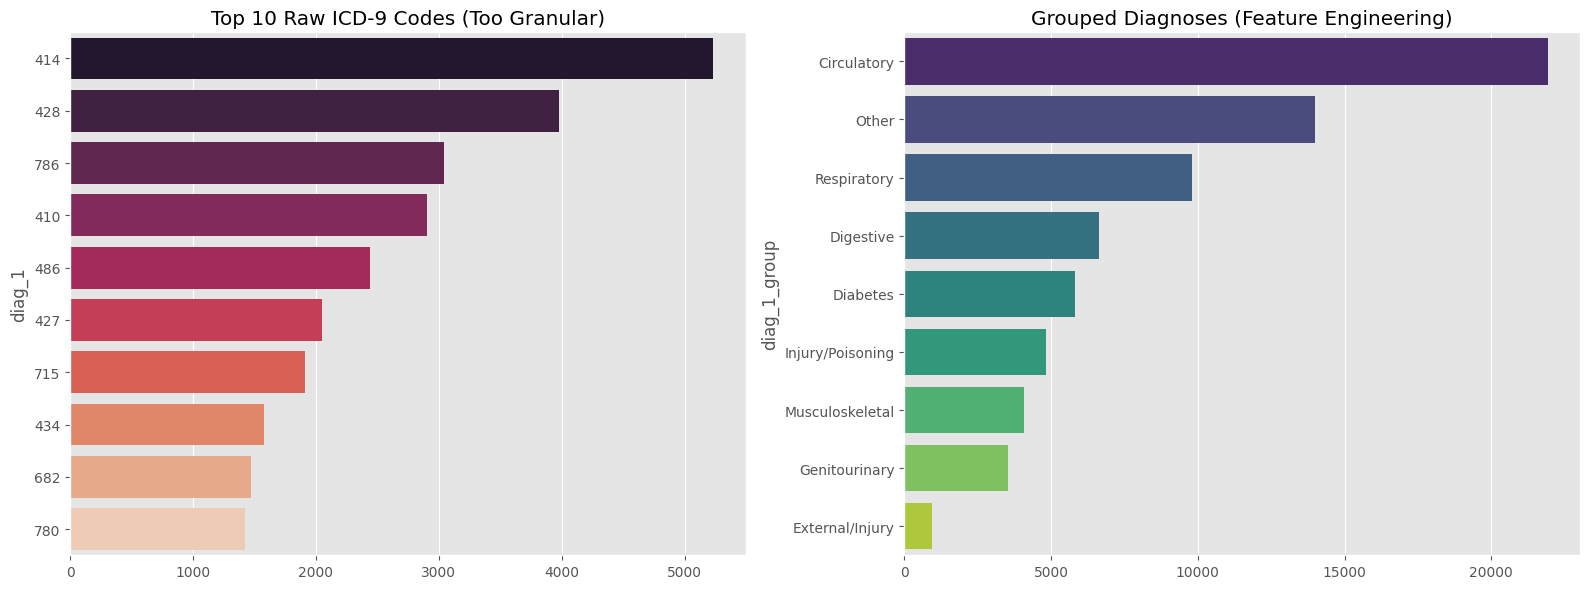

In [8]:
# Visualize Diagnosis Grouping Logic
# We show top 10 raw codes vs our grouped codes
df_clean = preprocess.load_and_clean_data('../data/diabetic_data.csv')
df_eng = feature_engineering.apply_feature_engineering(df_clean)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Raw Chaos
raw_counts = df_clean['diag_1'].value_counts().head(10)
sns.barplot(x=raw_counts.values, y=raw_counts.index, ax=axes[0], palette='rocket')
axes[0].set_title('Top 10 Raw ICD-9 Codes (Too Granular)')

# Plot 2: Engineered Clarity
group_counts = df_eng['diag_1_group'].value_counts()
sns.barplot(x=group_counts.values, y=group_counts.index, ax=axes[1], palette='viridis')
axes[1].set_title('Grouped Diagnoses (Feature Engineering)')

plt.tight_layout()
plt.show()

### Conclusion
The comparison above illustrates the value of our feature engineering:
1.  **Left Plot (Raw):** Shows the chaos of granular codes. The model would struggle to find patterns here without thousands of examples per code.
2.  **Right Plot (Grouped):** Shows clear, dense categories. This dimensionality reduction helps tree-based models (like Random Forest) find split points more effectively.

**Next Steps:** These insights (Drop Columns, Handle Imbalance, Group Diagnoses) are now implemented in our production pipeline (`src/preprocess.py` and `src/feature_engineering.py`).